In [3]:
import pandas as pd 
import sqlite3
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import plotly.express as px
import json 
from PIL import Image
import io
import math
from scipy.stats import zscore
%matplotlib inline

In [4]:
#Setting plotting style using matplotlib 
plt.style.use('classic')
sns.set(style='white')

In [32]:
#Load geojson files of Tehran, Mashhad and Isfahan
with open('tehran.geojson') as f:
    tehran_districts = json.load(f)

with open('mashhad.geojson') as f:
    mashhad_districts = json.load(f)

with open('isfahan.geojson') as f:
    isfahan_districts = json.load(f)

In [6]:
#Load data from sqlite database and rename price_per_m column 

conn = sqlite3.connect('db.sqlite')
query = """
select * from houses
"""
df = pd.read_sql_query(query, conn)
df.count
df.rename(columns={'price_per_m':'price_m'}, inplace = True)

In [12]:
# Some minor anomalies observed in price per meter calculation during the study, so decided to calculate 
# price per meter and replace calculated values in respective column
df['price_m'] = round(df['price'] * (df['percent']/100.0)/(df['area']), 2) 
df['month'] = df['date'].apply(lambda x:int(x[5:7]))
df['price'] = df['price'] * 1000
df['price_m'] = df['price_m'] * 1000

In [20]:
cols = ['contract_code', 'province', 'city',
       'mun_code', 'use_case', 'area', 'percent', 'price', 'price_m', 'age',
       'struct_type', 'month']
df = df[cols]

In [112]:
#Some minor flaws observed in structure type names, tried to make all names uniform 
mask = (df['struct_type'] == 'آجر یا بلوک سیمانی') | (df['struct_type'] == 'آجر يا بلوک سيماني')
df.loc[mask, 'struct_type'] = 'آجر يا بلوک سيماني'

/home/mahdi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
#Changing type of contract code column to object
df = df.astype({'contract_code':'object'})
df.dtypes

contract_code     object
province          object
city              object
mun_code         float64
use_case          object
area             float64
percent          float64
price              int64
price_m          float64
age                int64
struct_type       object
month              int64
dtype: object

At this we point we will do data cleaning, some columns would have data not in a reasonable range. 
First will go through null values and column data type checks.
Second will go through ['area', 'price_m', 'age'] columns to observe any unreasonable range of data. 

In [23]:
#The only columns got null values is municipality code column, so we set value of 1 to rows with no municipality value
df.isnull().sum()

contract_code         0
province              0
city                  0
mun_code         106641
use_case              0
area                  0
percent               0
price                 0
price_m               0
age                   0
struct_type           0
month                 0
dtype: int64

In [24]:
mask = df['mun_code'].isnull()
df.loc[mask,'mun_code'] = 1
df.isnull().sum()

contract_code    0
province         0
city             0
mun_code         0
use_case         0
area             0
percent          0
price            0
price_m          0
age              0
struct_type      0
month            0
dtype: int64

In [25]:
df.describe()

,mun_code,area,percent,price,price_m,age,month
count,221405.000000,2.214050e+05,221405.000000,2.214050e+05,2.214050e+05,221405.000000,221405.000000
mean,4.303625,4.715536e+03,99.033071,7.779451e+06,8.494150e+04,8.458386,6.933701
std,4.943620,2.125237e+06,7.916480,1.333017e+07,3.451371e+05,8.291840,3.764919
min,1.000000,1.000000e+00,0.000000,1.000000e+03,0.000000e+00,0.000000,1.000000
25%,1.000000,6.500000e+01,100.000000,2.040000e+06,2.497567e+04,2.000000,3.000000
50%,1.000000,8.386000e+01,100.000000,4.300000e+06,5.263158e+04,7.000000,8.000000
75%,6.000000,1.090000e+02,100.000000,8.950000e+06,1.050788e+05,13.000000,10.000000
max,22.000000,1.000000e+09,100.000000,1.910000e+09,4.500000e+07,99.000000,12.000000


Outlier observed in price per meter column. Global changing of outliers in whole data set will lead to loss of data coz different cities have different house pricing policy. So we applied Isolation Forest outlier detection algorithm to a breakdown batches of cities in different months. The best apporach would be the cinsideration of municipilaty code as well. 

In [43]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators = 100, contamination = 0.02)
codes = []
for city in df['city'].unique():
    mask = df['city'] == city
    for month in df[mask]['month'].unique():
        mask = (df['city'] == city) & (df['month'] == month)
        md = df.loc[mask, ['contract_code', 'price_m']]
        md['if'] = clf.fit_predict(df[mask]['price_m'].to_numpy().reshape((-1,1)))
        codes.extend(md[md['if'] == -1]['contract_code'].tolist())

mask_ol = df['contract_code'].isin(codes)
df.drop(df[mask_ol].index, inplace=True)


<AxesSubplot:xlabel='contract_code', ylabel='price_m'>

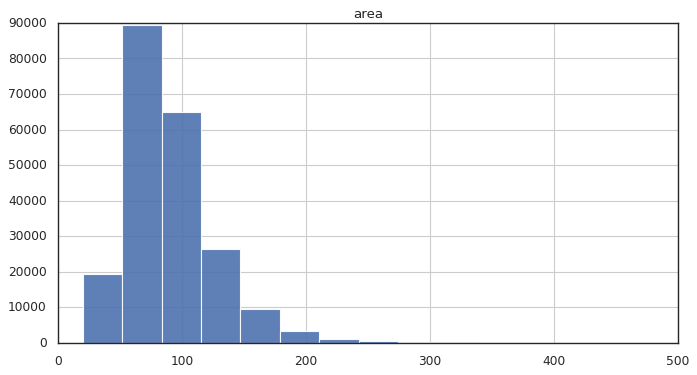

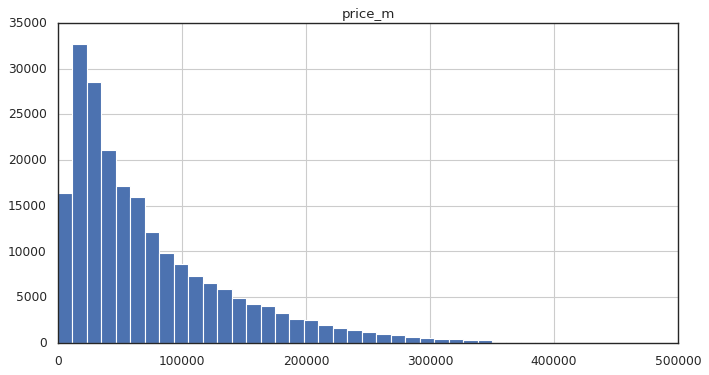

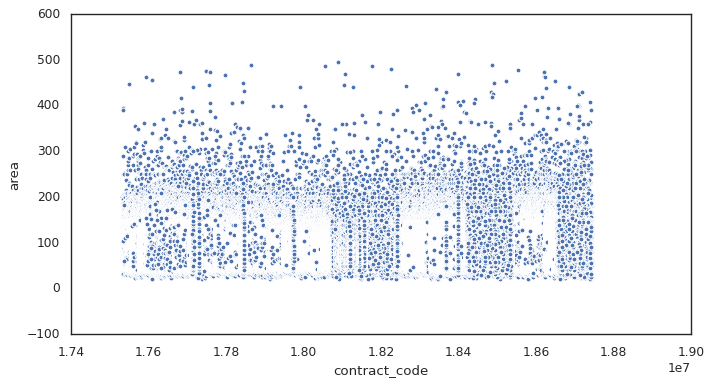

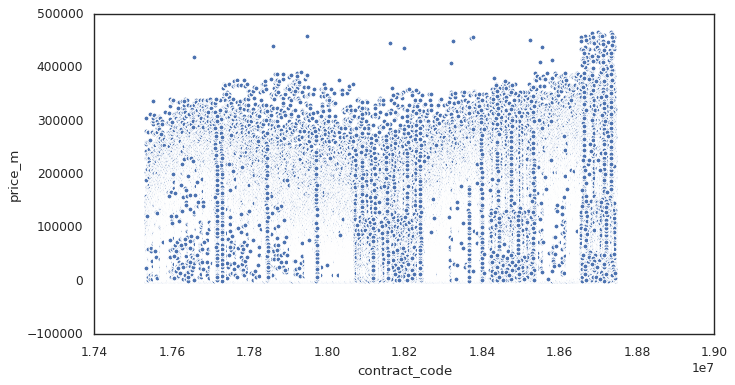

In [114]:
# we applied a filter to area column, considering only values between 20 and 500
mask = (df['area'] < 500) & (df['area']>20)
df[mask].describe()
df[mask][['area']].hist(bins = 15, figsize=(10,5), alpha=0.9)
df[mask][['price_m']].hist(bins = 40, figsize=(10,5))
df[mask][['area', 'contract_code']].plot(kind='scatter', x='contract_code', y='area',color='b', figsize=(10,5))
df[mask][['price_m', 'contract_code']].plot(kind='scatter', x='contract_code', y='price_m',color='b', figsize=(10,5))

Text(0, 0.5, 'Number of Deals')

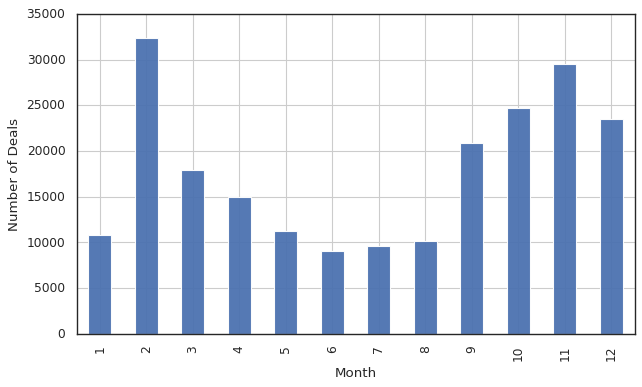

In [62]:
ax = df.groupby('month', as_index= False).count().plot(kind='bar', x='month', y='contract_code', 
figsize=(9,5), alpha = 0.95, legend=False)
ax.grid()
ax.set_xlabel('Month')
ax.set_ylabel('Number of Deals')

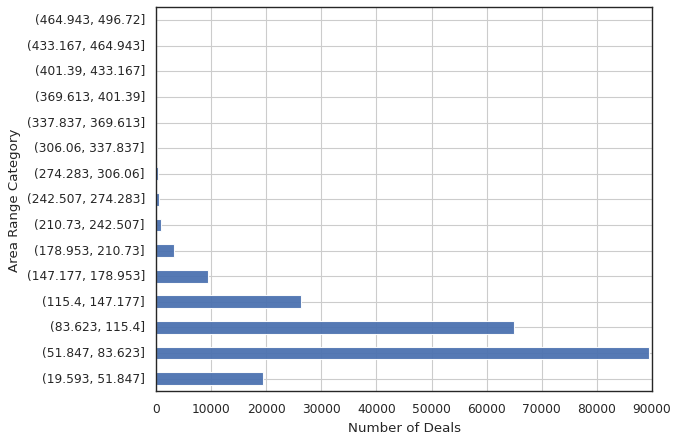

In [63]:
ax = pd.DataFrame({'area_gp':pd.cut(df['area'], 15), 'idx':df.index}).groupby('area_gp',
 as_index=False).count().plot(kind='barh', x='area_gp', y='idx', legend=False, alpha=0.95)
ax.set_xlabel('Number of Deals')
ax.set_ylabel('Area Range Category')
ax.grid()

In [64]:
bins = pd.IntervalIndex.from_tuples([(df.age.min()-1,5),(5,10), (10,15), (15, 20),(20, df.age.max())], closed='right')


Text(0, 0.5, '')

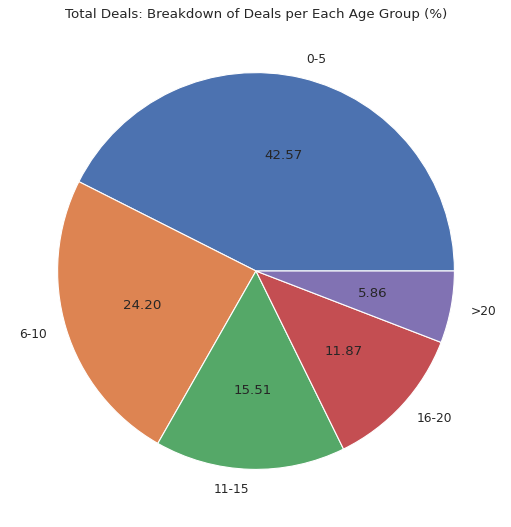

In [115]:
ax = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'idx':df.index}).groupby('age_gp',
 as_index=False).count().plot(kind='pie', y='idx', legend=False, labels =['0-5', '6-10', '11-15', '16-20', '>20'], 
 normalize=True, autopct='%.2f', figsize = (8,8), title='Total Deals: Breakdown of Deals per Each Age Group (%)')
ax.set_ylabel('')

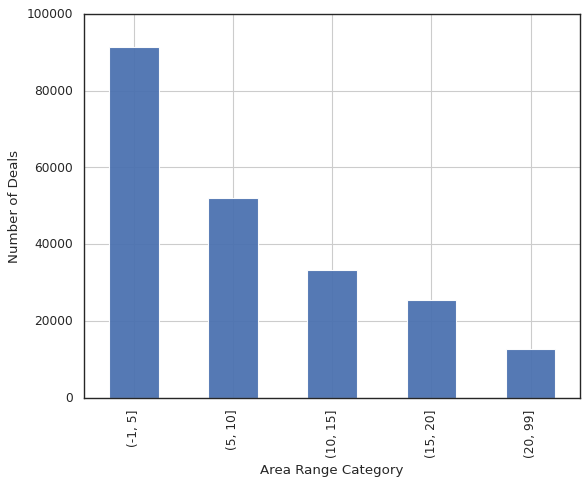

In [116]:
ax = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'idx':df.index}).groupby('age_gp',
 as_index=False).count().plot(kind='bar', x='age_gp', y='idx', legend=False, alpha=0.95)
ax.set_ylabel('Number of Deals')
ax.set_xlabel('Area Range Category')
ax.grid()

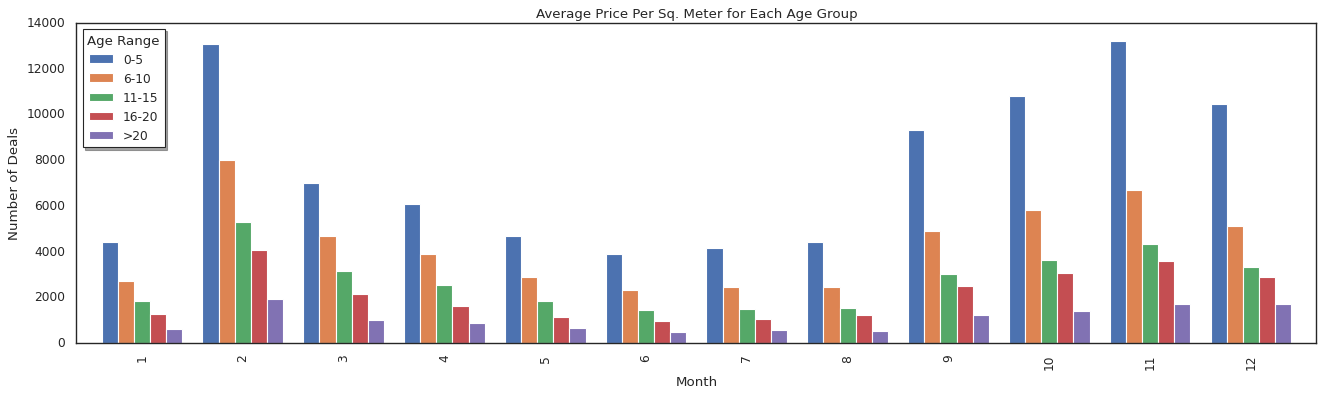

In [69]:
ax = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'price_m':df['price_m'], 'month':df['month']}).groupby(['month', 'age_gp'],
 as_index=True).count().unstack('age_gp').plot(kind='bar', figsize=(20, 5),
 title='Average Price Per Sq. Meter for Each Age Group', width=0.8)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Deals')
ax.legend(['0-5', '6-10', '11-15', '16-20', '>20'], loc='upper left', title='Age Range', shadow=True)

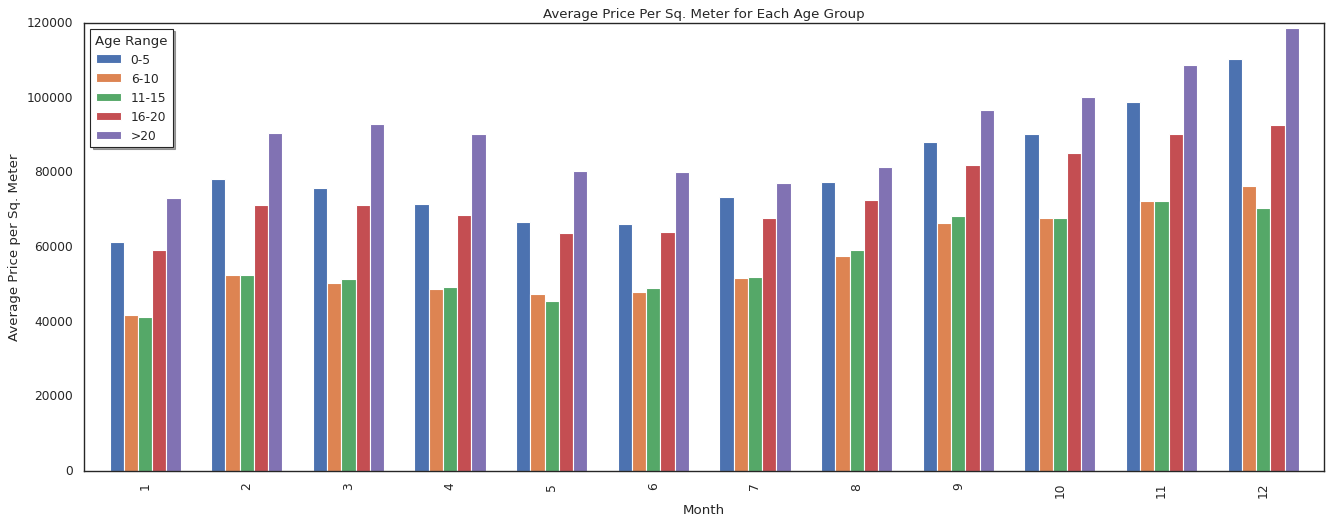

In [70]:
ax = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'price_m':df['price_m'], 'month':df['month']}).groupby(['month', 'age_gp'],
 as_index=True).mean().unstack('age_gp').plot(kind='bar', figsize=(20, 7), 
 title='Average Price Per Sq. Meter for Each Age Group', width=0.7)
ax.set_xlabel('Month')
ax.set_ylabel('Average Price per Sq. Meter')
ax.legend(['0-5', '6-10', '11-15', '16-20', '>20'], loc='upper left', title='Age Range', shadow=True)

The followings figure shows verage price per squared meter for different age range categories. The price for group 5 (>20 yrs) is higher than group 1 and one possible reason would be the bias in data points. Old houses in big cities outnumber the ones in small cities, and average price in large cities is way higher. 

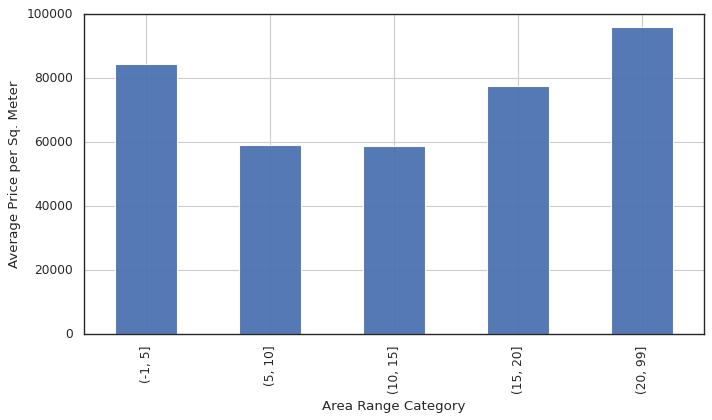

In [71]:
ax = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'price_m':df['price_m']}).groupby('age_gp',
 as_index=False).mean().plot(kind='bar', x='age_gp', y='price_m', legend=False, alpha=0.95, width=0.5, figsize=(10, 5))
ax.set_ylabel('Average Price per Sq. Meter')
ax.set_xlabel('Area Range Category')
ax.grid()

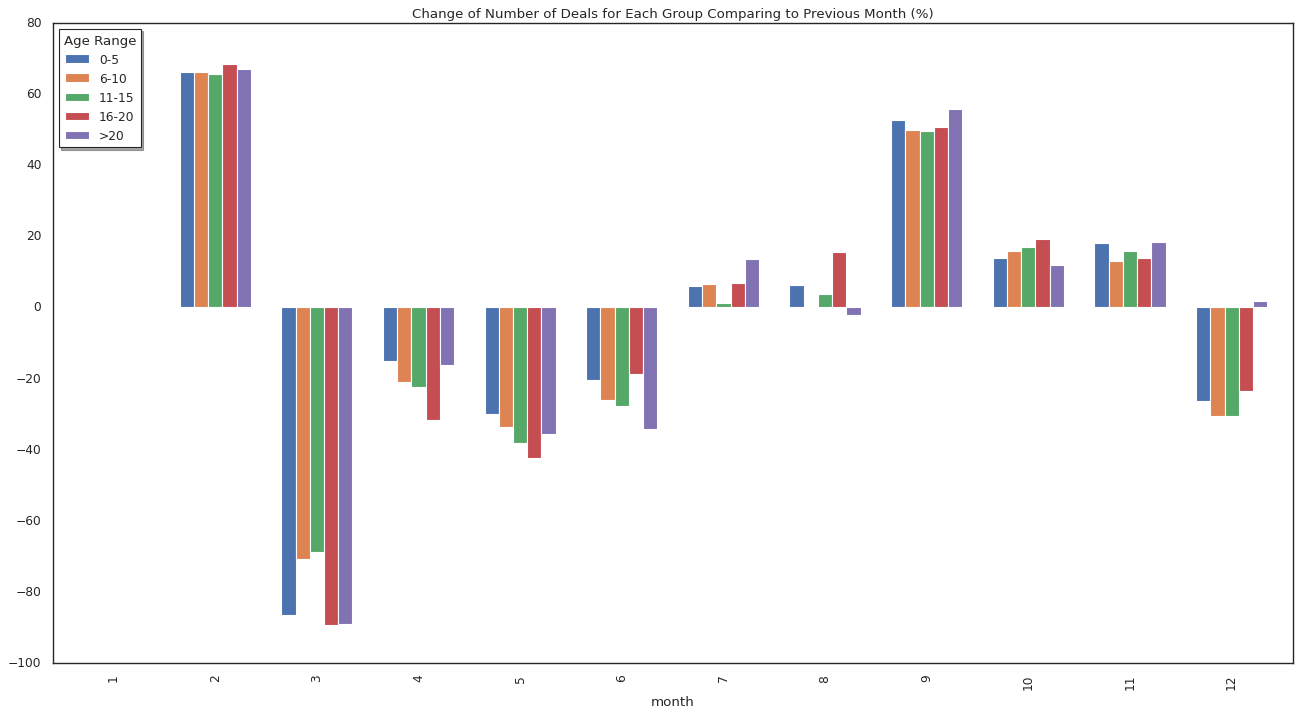

In [72]:
df_sub = pd.DataFrame({'age_gp':pd.cut(df['age'], bins), 'price_m':df['price_m'], 'month':df['month']}).groupby(['month', 'age_gp'],
 as_index=True).count().unstack('age_gp')

df_sub = (df_sub-df_sub.shift(1))/df_sub * 100.0
ax = df_sub.plot(kind='bar', figsize=(20, 10), width=0.7, title='Change of Number of Deals for Each Group Comparing to Previous Month (%)')
ax.legend(['0-5', '6-10', '11-15', '16-20', '>20'], loc='upper left', title='Age Range', shadow=True)

In [73]:
bins_area = pd.IntervalIndex.from_tuples([(0, 30),(30,45), (45,60), (60, 75),(75,90), (90,105), (105, 120), (120,135),
(135, 150), (150,165), (165, 180), (180, 195), (195, 210), (210, 225), (225, 240), (240, 255), (255, 270), (270,285), (285, 300), 
(300, 800)], closed='right')

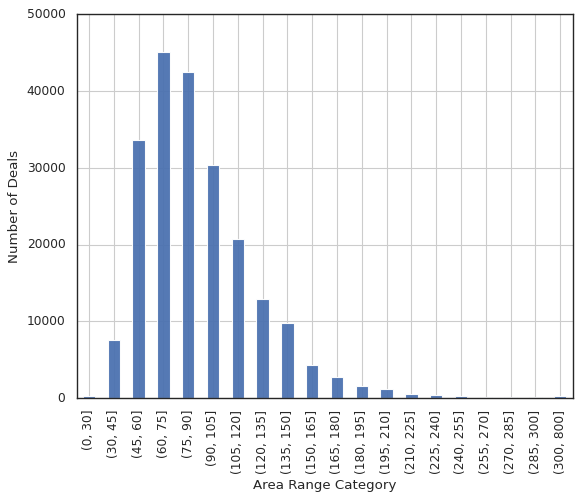

In [74]:
ax = pd.DataFrame({'area_gp':pd.cut(df['area'], bins_area), 'price_m':df['price_m']}).groupby('area_gp',
 as_index=False).count().plot(kind='bar', x='area_gp', y='price_m', legend=False, alpha=0.95)
ax.set_ylabel('Number of Deals')
ax.set_xlabel('Area Range Category')
ax.grid()

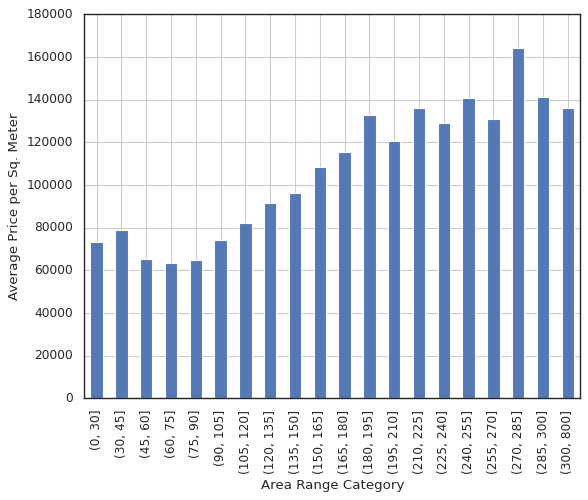

In [75]:
ax = pd.DataFrame({'area_gp':pd.cut(df['area'], bins_area), 'price_m':df['price_m']}).groupby('area_gp',
 as_index=False).mean().plot(kind='bar', x='area_gp', y='price_m', legend=False, alpha=0.95)
ax.set_ylabel('Average Price per Sq. Meter')
ax.set_xlabel('Area Range Category')
ax.grid()

Performing Analysis on capital city of Iran, Tehran

Text(0, 0.5, 'Number of Deals')

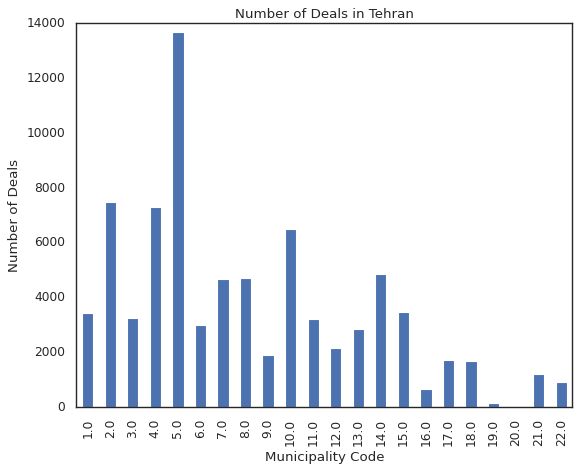

In [76]:
mask = df['city'] == 'تهران'
ax = df[mask].groupby('mun_code', as_index=False).count().plot(kind='bar', x='mun_code', y='contract_code', legend=False, 
title='Number of Deals in Tehran')
ax.set_xlabel('Municipality Code')
ax.set_ylabel('Number of Deals')

Text(0, 0.5, 'Average Prie per Sq. Meter')

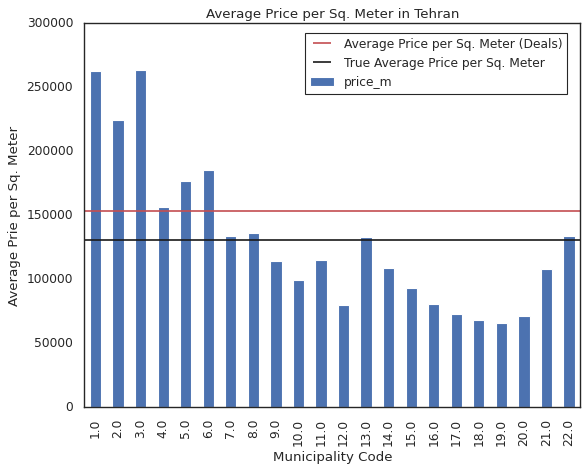

In [7]:
mask = df['city'] == 'تهران'
fig, ax = plt.subplots()
df[mask].groupby('mun_code', as_index=False).mean().plot(kind='bar', x='mun_code', y='price_m', legend=False, 
title='Average Price per Sq. Meter in Tehran', ax = ax)
ax.hlines(y=df[mask]['price_m'].mean(), color = 'r', xmin=-1, xmax = 22,label = 'Average Price per Sq. Meter (Deals)')
ax.hlines(y=df[mask].groupby('mun_code', as_index=False).mean()[['price_m']].mean()['price_m'], color = 'k', xmin=-1, xmax = 22, label = 'True Average Price per Sq. Meter')
fig.legend(bbox_to_anchor=(0.88,0.88),loc = 'upper right', borderaxespad = 0)
ax.set_xlabel('Municipality Code')
ax.set_ylabel('Average Prie per Sq. Meter')


In [30]:
#Deals counts per districts in Tehran 
md = df[df['city'] == 'تهران'].groupby('mun_code', as_index=False).count()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=tehran_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 35.715298, "lon": 51.404343},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Deals Count'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [31]:
#Average price per sq. meter for districts in Tehran
md = df[df['city'] == 'تهران'].groupby('mun_code', as_index=False).mean().copy()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=tehran_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 35.715298, "lon": 51.404343},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Average Price per Meter(Rls)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [35]:
#Deals counts per districts in Mashhad 
md = df[df['city'] == 'مشهد'].groupby('mun_code', as_index=False).count()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=mashhad_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 36.310699, "lon": 59.599457},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Deals Count'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [36]:
#Average price per sq. meter for districts in Mashhad
md = df[df['city'] == 'مشهد'].groupby('mun_code', as_index=False).mean().copy()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=mashhad_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 36.310699, "lon": 59.599457},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Average Price per Meter(Rls)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [37]:
#Deals counts per districts in Isfahan 
md = df[df['city'] == 'اصفهان'].groupby('mun_code', as_index=False).count()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=isfahan_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 32.661343, "lon": 51.680374},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Deals Count'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [38]:
#Average price per sq. meter for districts in Isfahan
md = df[df['city'] == 'اصفهان'].groupby('mun_code', as_index=False).mean().copy()
fig = px.choropleth_mapbox(md, locations='mun_code' , geojson=isfahan_districts,
                           featureidkey='properties.area',
                           color = 'price_m',
                           center={"lat": 32.661343, "lon": 51.680374},
                           color_continuous_scale="Viridis",
                           range_color=(md.price_m.min(), md.price_m.max()),
                           mapbox_style="carto-positron",
                           zoom=9,
                           opacity=0.7,
                           labels={'mun_code':'Municipality Code', 'price_m':'Average Price per Meter(Rls)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Text(0, 0.5, '')

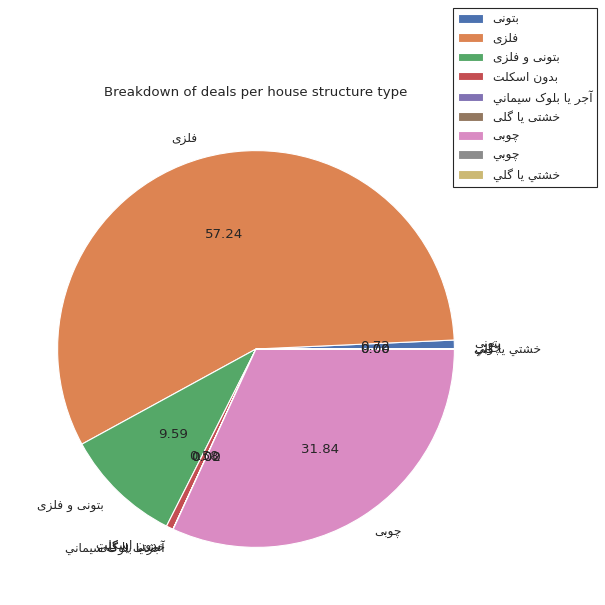

In [108]:
from bidi.algorithm import get_display
from arabic_reshaper import reshape
labels = [get_display(reshape(label)) for label in df.struct_type.unique()]
ax = df.groupby('struct_type', as_index = False).count().plot(kind='pie', y='contract_code', legend=True,labels = labels, 
normalize=True, autopct='%.2f', figsize = (8,8), title = 'Breakdown of deals per house structure type')
ax.legend(loc='upper right', bbox_to_anchor = (1.2,1.2))
ax.set_ylabel('')